# Google Drive Mounting I/O

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Dataset path
DATASET = '/content/gdrive/MyDrive/IndonesiaAI/Project 1 - Face Recognition/Dataset/Dataset_5K'
TRAIN = DATASET + '//' + 'train'
VALIDATION = DATASET + '//' + 'validation'
TEST = DATASET + '//' + 'test'
EXAMPLE_IMAGE = '/content/gdrive/MyDrive/IndonesiaAI/Project 1 - Face Recognition/Dataset/Dataset_5K/train/male/000012.jpg'

# Setting Up The Environment

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow_hub as hub

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

# Data Loading

In [5]:
SEED = 56
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [6]:
# Check if the file exists
if os.path.exists(EXAMPLE_IMAGE):
    img = cv2.imread(EXAMPLE_IMAGE)
    if img is not None:
        print(img.shape)
    else:
        print("Failed to load the image.")
else:
    print("Image file not found at the specified path.")

(218, 178, 3)


In [7]:
# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    labels="inferred",
    label_mode="binary",
    shuffle=True,
    seed=SEED,
    validation_split=None,
    subset=None,
)

# Create the validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    labels="inferred",
    label_mode="binary",
    shuffle=False,  # Set shuffle to False for the validation dataset
    seed=SEED,
    validation_split=None,
    subset=None,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    labels="inferred",
    label_mode="binary",
    shuffle=False,  # Set shuffle to False for the test dataset
)

Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [8]:
print(train_ds.class_names)
print(validation_ds.class_names)

['female', 'male']
['female', 'male']


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32, 1)


In [10]:
for image_batch, labels_batch in validation_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32, 1)


In [11]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32, 1)


# Exploratory Data Analysis

In [12]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     # Convert labels[i] to a NumPy array and then extract the integer value
#     label_index = int(labels[i].numpy()[0])  # Convert to int and index the first element
#     plt.title(class_names[label_index])
#     plt.axis("off")

# Data Augmentation

In [13]:
image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2),
])

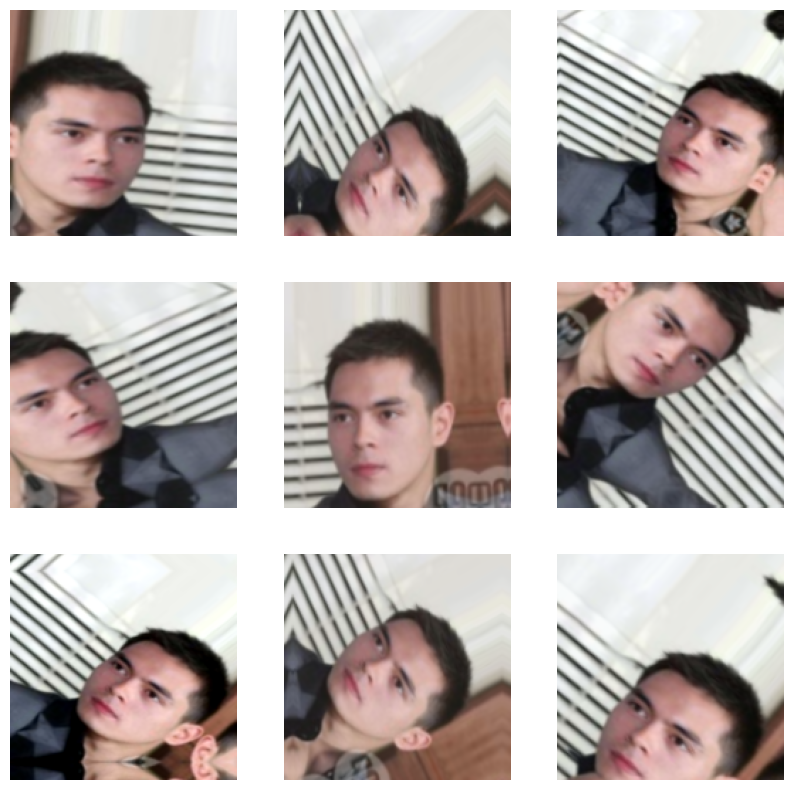

In [14]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = image_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Model Building

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input

# Load the VGG19 model without the top classification layer (include_top=False)
vgg19_base_model = VGG19(weights='imagenet', include_top=False)

preprocess_input_vgg19 = vgg19_preprocess_input

80134624/80134624 [==============================] - 0s 0us/step


In [17]:
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input as resnet101_preprocess_input

# Load the ResNet101 model without the top classification layer (include_top=False)
resnet101_base_model = ResNet101(weights='imagenet', include_top=False)

preprocess_input_resnet101 = resnet101_preprocess_input

171446536/171446536 [==============================] - 1s 0us/step


In [18]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

def build_transfer_learning_model(base_model, preprocess_input, image_augmentation, use_dropout=True):
    # Define the input shape
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Adjust to your image size and channels

    # Define the input layer with optional image augmentation
    input = Input(shape=input_shape)
    x = input
    x = image_augmentation(x)
    x = Rescaling(1.0 / 255)(x)  # Normalize pixel values to [0, 1]

    # Apply preprocessing specific to the chosen base_model
    x = preprocess_input(x)

    # Create the base model (pre-trained model)
    x = base_model(x)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer to extract features
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer for binary classification (female/male)
    x = Dense(1024, activation='relu')(x)

    # Add dropout for regularization (optional)
    if use_dropout:
        x = Dropout(0.2)(x)

    # Add the output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=input, outputs=output)

    return model


In [19]:
# Build the VGG19-based transfer learning model
VGG19_model = build_transfer_learning_model(base_model=vgg19_base_model,
                                           preprocess_input=preprocess_input_vgg19,
                                           image_augmentation=image_augmentation,
                                           use_dropout=True)

In [20]:
# Build the VGG19-based transfer learning model
RESNET101_model = build_transfer_learning_model(base_model=resnet101_base_model,
                                           preprocess_input=preprocess_input_resnet101,
                                           image_augmentation=image_augmentation,
                                           use_dropout=True)

# Model Training

In [21]:
# Compile the model
VGG19_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [22]:
# Train the model
num_epochs = 10  # Adjust as needed
vgg_history = VGG19_model.fit(train_ds, validation_data=validation_ds, epochs=num_epochs)


Epoch 1/10
125/125 [==============================] - 340s 3s/step - loss: 0.7701 - accuracy: 0.4897 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7286 - accuracy: 0.4967 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 3/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7204 - accuracy: 0.4983 - val_loss: 0.6914 - val_accuracy: 0.5280
Epoch 4/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7146 - accuracy: 0.4967 - val_loss: 0.6961 - val_accuracy: 0.5100
Epoch 5/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7090 - accuracy: 0.5033 - val_loss: 0.6966 - val_accuracy: 0.5100
Epoch 6/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7060 - accuracy: 0.5033 - val_loss: 0.6922 - val_accuracy: 0.5080
Epoch 7/10
125/125 [==============================] - 11s 89ms/step - loss: 0.7022 - accuracy: 0.5092 - val_loss: 0.6918 - val_accuracy: 

In [23]:
# Compile the model
RESNET101_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [24]:
# Train the model
num_epochs = 10  # Adjust as needed
resnet101_history = RESNET101_model.fit(train_ds, validation_data=validation_ds, epochs=num_epochs)

Epoch 1/10
125/125 [==============================] - 25s 138ms/step - loss: 0.7272 - accuracy: 0.4978 - val_loss: 0.6705 - val_accuracy: 0.6360
Epoch 2/10
125/125 [==============================] - 14s 114ms/step - loss: 0.6945 - accuracy: 0.5295 - val_loss: 0.6719 - val_accuracy: 0.5420
Epoch 3/10
125/125 [==============================] - 14s 114ms/step - loss: 0.6908 - accuracy: 0.5415 - val_loss: 0.6703 - val_accuracy: 0.5440
Epoch 4/10
125/125 [==============================] - 14s 114ms/step - loss: 0.6868 - accuracy: 0.5590 - val_loss: 0.6628 - val_accuracy: 0.5960
Epoch 5/10
125/125 [==============================] - 14s 115ms/step - loss: 0.6873 - accuracy: 0.5480 - val_loss: 0.6597 - val_accuracy: 0.6720
Epoch 6/10
125/125 [==============================] - 15s 123ms/step - loss: 0.6858 - accuracy: 0.5460 - val_loss: 0.6571 - val_accuracy: 0.6480
Epoch 7/10
125/125 [==============================] - 14s 115ms/step - loss: 0.6834 - accuracy: 0.5518 - val_loss: 0.6602 - val_ac

# Save The Model

In [25]:
import os

# Create the root directory
root_dir = "/content/gdrive/MyDrive/IndonesiaAI/Project 1 - Face Recognition/Model_Saver"
os.makedirs(root_dir, exist_ok=True)

# Create subdirectories for VGG19 and ResNet101 models
vgg19_dir = os.path.join(root_dir, "vgg19_model")
resnet101_dir = os.path.join(root_dir, "resnet101_model")
os.makedirs(vgg19_dir, exist_ok=True)
os.makedirs(resnet101_dir, exist_ok=True)

# Save the VGG19 model to the VGG19 directory
VGG19_model.save(os.path.join(vgg19_dir, "vgg19_model_v1.h5"))

# Save the ResNet101 model to the ResNet101 directory
RESNET101_model.save(os.path.join(resnet101_dir, "resnet101_model_v1.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation

In [26]:
# from sklearn.metrics import classification_report, confusion_matrix

# # Define the root directory
# root_dir = "model_save"

# # Load the VGG19 model
# vgg19_dir = os.path.join(root_dir, "vgg19_model")
# loaded_vgg19_model = tf.keras.models.load_model(os.path.join(vgg19_dir, "vgg19_model_v1.h5"))

# # Load the ResNet101 model
# resnet101_dir = os.path.join(root_dir, "resnet101_model")
# loaded_resnet101_model = tf.keras.models.load_model(os.path.join(resnet101_dir, "resnet101_model_v1.h5"))

# # Evaluate the VGG19 model
# vgg19_test_results = loaded_vgg19_model.evaluate(test_dataset, verbose=0)
# print("VGG19 Test Results:")
# print(f"Loss: {vgg19_test_results[0]:.4f}")
# print(f"Accuracy: {vgg19_test_results[1]*100:.2f}%")
# print()

# # # Evaluate the ResNet101 model
# # resnet101_test_results = loaded_resnet101_model.evaluate(test_dataset, verbose=0)
# # print("ResNet101 Test Results:")
# # print(f"Loss: {resnet101_test_results[0]:.4f}")
# # print(f"Accuracy: {resnet101_test_results[1]*100:.2f}%")
# # print()

# # Generate predictions and evaluate additional metrics
# def evaluate_model(model, dataset, model_name):
#     y_pred = model.predict(dataset)
#     y_true = [y for x, y in dataset]

#     # Convert one-hot encoded labels to class labels
#     y_pred_labels = tf.argmax(y_pred, axis=1)
#     y_true_labels = tf.argmax(y_true, axis=1)

#     # Generate a classification report
#     classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=["female", "male"])
#     print(f"{model_name} Classification Report:")
#     print(classification_report_result)
#     print()

#     # Generate a confusion matrix
#     confusion_matrix_result = confusion_matrix(y_true_labels, y_pred_labels)
#     print(f"{model_name} Confusion Matrix:")
#     print(confusion_matrix_result)
#     print()

# # Evaluate the VGG19 model with additional metrics
# evaluate_model(loaded_vgg19_model, test_dataset, "VGG19")

# # # Evaluate the ResNet101 model with additional metrics
# # evaluate_model(loaded_resnet101_model, test_dataset, "ResNet101")
